In [22]:
import chainer
from chainer import functions as F
import gym
import gym.wrappers
import numpy as np
from chainerrl.agents import a3c
from chainerrl.agents import PPO
from chainerrl import experiments
from chainerrl import links
from chainerrl import misc
from chainerrl.optimizers.nonbias_weight_decay import NonbiasWeightDecay
from chainerrl import policies

import matplotlib.pyplot as plt

In [23]:
def phi(obs):
    return obs.astype(np.float32)

In [24]:
class A3CFFGaussian(chainer.Chain, a3c.A3CModel):
    """An example of A3C feedforward Gaussian policy."""

    def __init__(self, obs_size, action_space,
                 n_hidden_layers=2, n_hidden_channels=64,
                 bound_mean=None, normalize_obs=None):
        assert bound_mean in [False, True]
        assert normalize_obs in [False, True]
        super().__init__()
        hidden_sizes = (n_hidden_channels,) * n_hidden_layers
        self.normalize_obs = normalize_obs
        with self.init_scope():
            self.pi = policies.FCGaussianPolicyWithStateIndependentCovariance(
                obs_size, action_space.low.size,
                n_hidden_layers, n_hidden_channels,
                var_type='diagonal', nonlinearity=F.tanh,
                bound_mean=bound_mean,
                min_action=action_space.low, max_action=action_space.high,
                mean_wscale=1e-2)
            self.v = links.MLP(obs_size, 1, hidden_sizes=hidden_sizes)
            if self.normalize_obs:
                self.obs_filter = links.EmpiricalNormalization(
                    shape=obs_size
                )

    def pi_and_v(self, state):
        if self.normalize_obs:
            state = F.clip(self.obs_filter(state, update=False),
                           -5.0, 5.0)

        return self.pi(state), self.v(state)

In [25]:
gpu = -1
env_name = "BipedalWalker-v2"
seed = 0

In [26]:
def make_env():
    env = gym.make(env_name)
    env.seed(seed)
    misc.env_modifiers.make_rendered(env)
    return env

env = make_env()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [27]:
timestep_limit = env.spec.tags.get("wrapper_config.TimeLimit.max_episode_steps")
obs_space = env.observation_space
action_space = env.action_space

print(timestep_limit)
print(obs_space)
print(action_space)

1600
Box(24,)
Box(4,)


In [28]:
model = A3CFFGaussian(obs_space.low.size, action_space, bound_mean=False, normalize_obs=False)

In [29]:
opt = chainer.optimizers.Adam(alpha=3e-4, eps=1e-5)

In [30]:
opt.setup(model)

In [37]:
agent = PPO(model, opt, gpu=-1, phi=phi, update_interval=2048, minibatch_size=64, epochs=10, clip_eps_vf=None, entropy_coef=0.0, standardize_advantages=False)

In [38]:
agent.load("10000000_finish")

In [111]:
obs = env.reset()
t = 0
episode_r = 0
done = False

value_list = []
dist_list = []
action_list = []

while not (t == 20 or done):
    action = agent.act(obs)
    a_dist, val = agent.model(agent.batch_states([obs], agent.xp, agent.phi))
    
    dist_list.append(a_dist)
    value_list.append(val.data[0][0])
    action_list.append(action)
    
    obs, r, done, info = env.step(action)
    
    t += 1
    episode_r += r

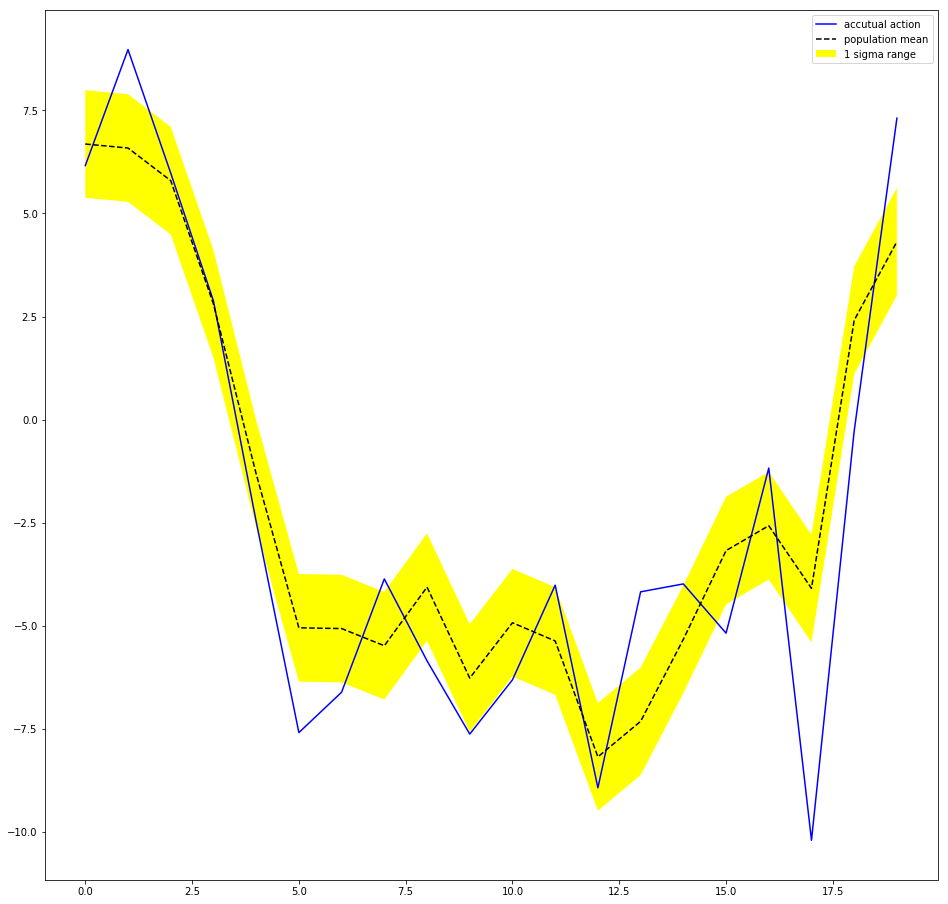

In [117]:
fig = plt.figure(figsize=[16, 16])
ax = fig.add_subplot(111)

a1_mean_list = []
a1_var_list = []
a1_list = []
time = np.arange(0, t)

for dist in dist_list:
    a1_mean_list.append(dist.mean[0][0].data)
    a1_var_list.append(dist.ln_var[0][0].data)


for item in action_list:
    a1_list.append(item[0])
    
a1_mean_list = np.array(a1_mean_list)
a1_var_list = np.array(a1_var_list)

lower_bound = a1_mean_list - np.sqrt(a1_var_list)
upper_bound = a1_mean_list + np.sqrt(a1_var_list)

ax.plot(time, a1_list, color="blue", label="accutual action")
ax.plot(time, a1_mean_list, color="black", label="population mean", ls="--")
ax.fill_between(time, lower_bound, upper_bound, facecolor="yellow", label="1 sigma range")
ax.legend(loc="upper right")

plt.show()

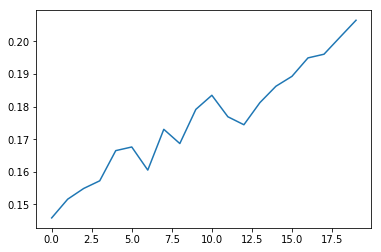

In [118]:
plt.plot(time, value_list[0:t])